```
Name: Train&Validation.ipynb
Description: Train and validation proposed NEtwork
Author: Behzad Valipour Sh. <behzad.valipour@outlook.com>
Date: 04.09.2022
MIT License

Copyright (c) 2022 Behzad Valipour Sh.

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

In [35]:
from src import LoadImageData, SyntheticS2Image

import torch
from torch import nn, optim
import torchmetrics

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns

from geoutils import utils
from PIL import Image

from tqdm import tqdm
from random import sample
import numpy as np
import os,sys

In [4]:
transform = A.Compose([ToTensorV2()])

In [5]:
# Constants
n_epochs = 5
batch_size = 16

In [6]:
train_data = LoadImageData('../data/train_data.geojson',
                           '../data/S2_B4328_10m_05072019.tif',
                           '../data/S2_B4328_10m_24082019.tif',
                           '../data/S1_VH_VV_10m_25072019_aligned.tif',
                           '../data/S2_B4328_10m_25072019.tif',
                           transform=transform)

valid_data = LoadImageData('../data/valid_data.geojson',
                           '../data/S2_B4328_10m_05072019.tif',
                           '../data/S2_B4328_10m_24082019.tif',
                           '../data/S1_VH_VV_10m_25072019_aligned.tif',
                           '../data/S2_B4328_10m_25072019.tif',
                           transform=transform)

test_data = LoadImageData('../data/test_data.geojson',
                           '../data/S2_B4328_10m_05072019.tif',
                           '../data/S2_B4328_10m_24082019.tif',
                           '../data/S1_VH_VV_10m_25072019_aligned.tif',
                           '../data/S2_B4328_10m_25072019.tif',
                           transform=transform)

In [7]:
train_loader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True,num_workers=20,pin_memory=True)
validation_loader = DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=False,num_workers=20,pin_memory=True)
test_loader = DataLoader(dataset=test_data,batch_size=batch_size,shuffle=False,num_workers=20,pin_memory=True)

In [8]:
class SyntheticS2Model(pl.LightningModule):
    def __init__(self,learning_rate = 0.0001):
        super(SyntheticS2Model,self).__init__()
        
        
        self.model = SyntheticS2Image()
        self.learning_rate = learning_rate
        self.loss = nn.MSELoss()
        self.save_hyperparameters()
        
    def forward(self,s2b,s2a,s1):
        return self.model(s2b,s2a,s1)
    
    def training_step(self, batch, batch_idx):
        s2b,s2a,s1,y = batch
        
        pred = self(s2b,s2a,s1)
        loss = self.loss(pred,y)
        self.log('Train_Loss', loss, on_epoch=True, on_step=True,prog_bar=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        s2b,s2a,s1,y = batch
        
        pred = self(s2b,s2a,s1)
        loss = self.loss(pred,y)
        self.log('validation_Loss', loss, on_epoch=True, on_step=True, prog_bar=True)
        return loss
        
        
    def test_step(self, batch, batch_idx):
        s2b,s2a,s1,y = batch
        pred = self(s2b,s2a,s1)
        loss = self.loss(pred,y)
        self.log('Test_Loss', loss, on_epoch=True, on_step=True)
        return loss
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=self.learning_rate)
        return optimizer

In [10]:
model = SyntheticS2Model()
ckpt_dir = "/scicore/home/roeoesli/valipo0000/training/marmande/model"
early_stop_callback = EarlyStopping(monitor="validation_Loss_epoch", patience=10,min_delta=0.01, verbose=True, mode="min")
ckpt_callback = pl.callbacks.ModelCheckpoint(filename="SyntheticS2Model-0.0.1_{epoch:02d}-{validation_Loss_epoch:.6f}",monitor='validation_Loss_epoch',mode='min',verbose=True)
trainer = pl.Trainer(default_root_dir=ckpt_dir,accelerator="gpu", devices=6, strategy="dp",
                        callbacks=[ckpt_callback,early_stop_callback],
                        log_every_n_steps=10,
                        max_epochs=n_epochs,
                        fast_dev_run=False
                    )
trainer.fit(model, train_dataloaders=train_loader,val_dataloaders=validation_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name  | Type             | Params
-------------------------------------------
0 | model | SyntheticS2Image | 73.8 M
1 | loss  | MSELoss          | 0     
-------------------------------------------
73.8 M    Trainable params
0         Non-trainable params
73.8 M    Total params
295.370   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric validation_Loss_epoch improved. New best score: 0.011
Epoch 0, global step 1128: 'validation_Loss_epoch' reached 0.01121 (best 0.01121), saving model to '/scicore/home/roeoesli/valipo0000/training/marmande/model/lightning_logs/version_53548107/checkpoints/SyntheticS2Model-0.0.1_epoch=00-validation_Loss_epoch=0.011211.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 2256: 'validation_Loss_epoch' reached 0.01109 (best 0.01109), saving model to '/scicore/home/roeoesli/valipo0000/training/marmande/model/lightning_logs/version_53548107/checkpoints/SyntheticS2Model-0.0.1_epoch=01-validation_Loss_epoch=0.011087.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 3384: 'validation_Loss_epoch' reached 0.01103 (best 0.01103), saving model to '/scicore/home/roeoesli/valipo0000/training/marmande/model/lightning_logs/version_53548107/checkpoints/SyntheticS2Model-0.0.1_epoch=02-validation_Loss_epoch=0.011032.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 4512: 'validation_Loss_epoch' reached 0.01087 (best 0.01087), saving model to '/scicore/home/roeoesli/valipo0000/training/marmande/model/lightning_logs/version_53548107/checkpoints/SyntheticS2Model-0.0.1_epoch=03-validation_Loss_epoch=0.010873.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 5640: 'validation_Loss_epoch' was not in top 1


# Validation

In [9]:
model_ = SyntheticS2Model()
train_model = model_.load_from_checkpoint(checkpoint_path='/scicore/home/roeoesli/valipo0000/training/marmande/model/lightning_logs/version_53548107/checkpoints/SyntheticS2Model-0.0.1_epoch=03-validation_Loss_epoch=0.010873.ckpt')

In [25]:
mse = nn.MSELoss()
err_list=[]
with torch.no_grad():
    for a, b, c, img in tqdm(test_loader,position=0, leave=True):
        true = img
        pred = train_model(a,b,c)
        err = mse(pred,true)
        err_list.append(err.cpu().numpy())

print(f'Mean Squared Error for Test data is: {np.array(err_list).mean()}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [13:01<00:00, 15.94s/it]

Mean Squared Error for Test data is: 0.01233593188226223


In [28]:
cloudy_data = LoadImageData('../data/patches_without_filter.geojson',
                           '../data/S2_B4328_10m_05072019.tif',
                           '../data/S2_B4328_10m_24082019.tif',
                           '../data/S1_VH_VV_10m_25072019_aligned.tif',
                           '../data/S2_B4328_10m_25072019.tif',
                           transform=transform)

In [29]:
cloud_loader = DataLoader(dataset=cloudy_data,batch_size=batch_size,shuffle=False,num_workers=20,pin_memory=True)

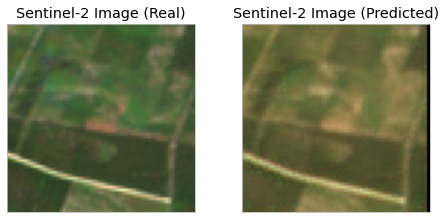

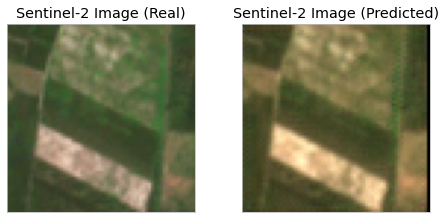

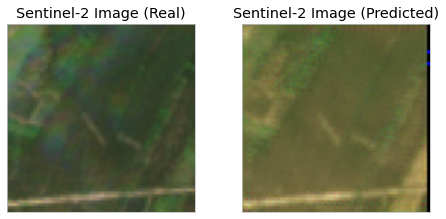

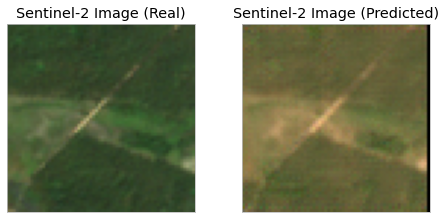

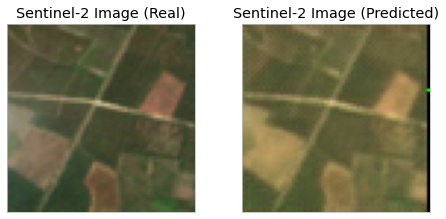

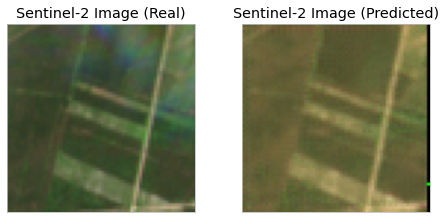

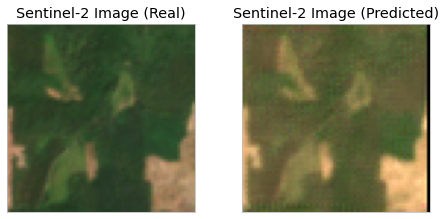

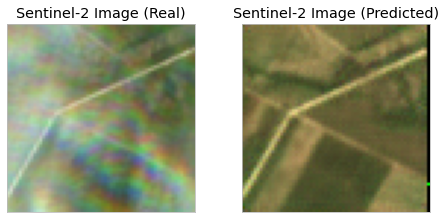

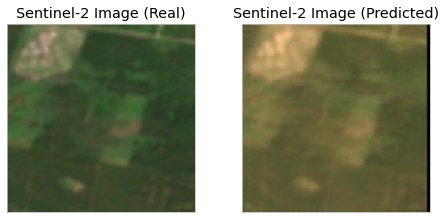

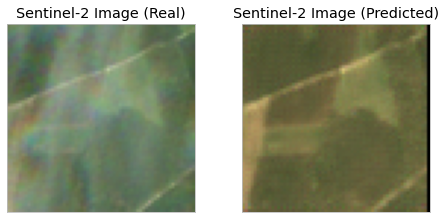

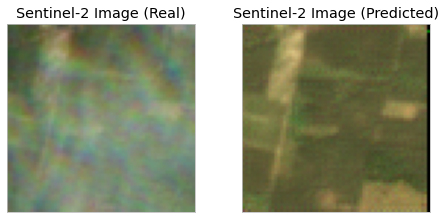

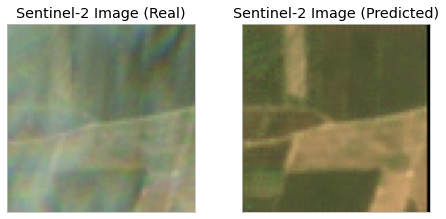

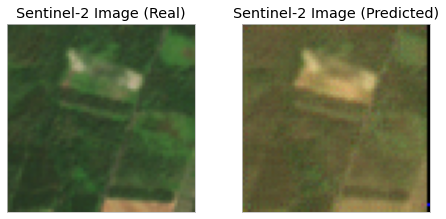

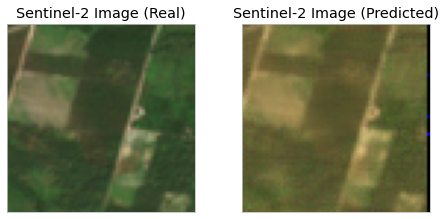

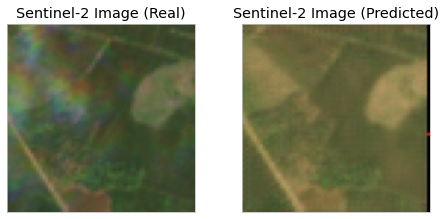

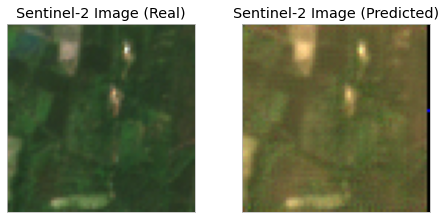

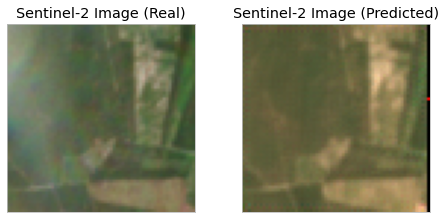

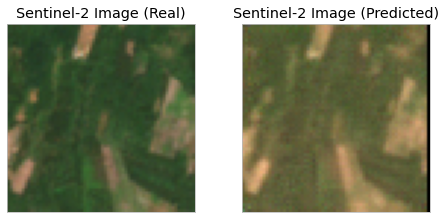

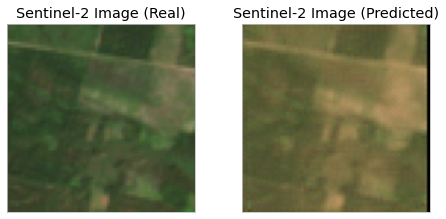

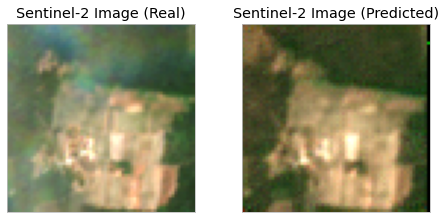

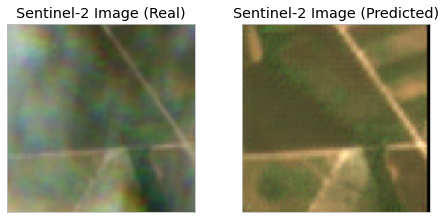

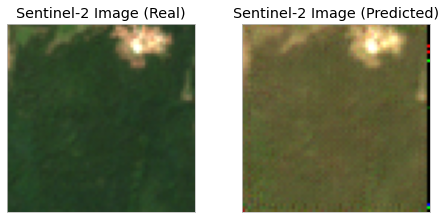

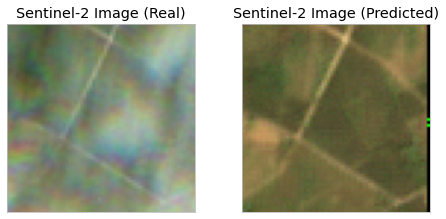

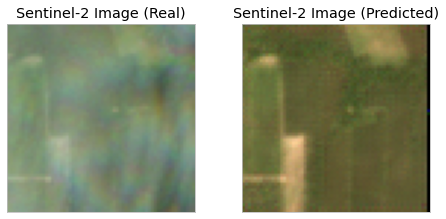

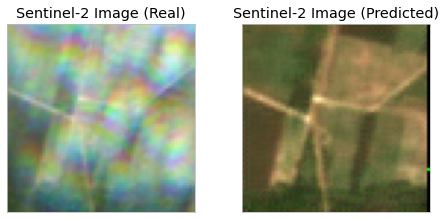

In [51]:
with torch.no_grad():
    for i in sample(range(0, len(cloud_loader)), 25):
        fig = plt.figure(1, figsize=([16, 8]))
        gs = plt.GridSpec(1,4, wspace=0.25, hspace=0.25)


        # Panel 01
        xtr_subsplot= fig.add_subplot(gs[:,:1])
        plt.title('Sentinel-2 Image (Real)')
        plt.imshow(np.moveaxis(np.clip(cloudy_data[i][3][0:3,...]*4,0,1).cpu().detach().numpy(),0,-1))   
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # Panel 02
        a,b,c = cloudy_data[i][0:3]
        pred_S2 = train_model(a.unsqueeze(0),b.unsqueeze(0),c.unsqueeze(0)).to('cpu').numpy()
        xtr_subsplot= fig.add_subplot(gs[:,1:2])
        plt.title('Sentinel-2 Image (Predicted)')
        plt.imshow(np.moveaxis(np.clip(pred_S2[0,0:3,...]*4,0,1),0,-1))   
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        
        # plt.savefig(f'../data/visualization/s2_{i}.png', dpi=300,bbox_inches="tight")
        plt.show()
        # plt.close()
        # if i==50:
        #     break

In [50]:
fp_out = "../data/visualization/systhetic_S2.gif"

img, *imgs = [Image.open(f) for f in sorted(utils.list_files_with_absolute_paths('../data/visualization/',endswith='png'))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=600, loop=0)